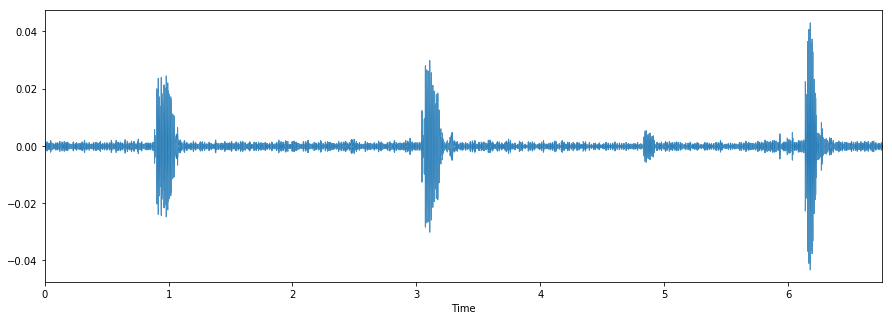

In [9]:
# We'll need numpy for some mathematical operations
import numpy as np

# Librosa for audio
import librosa, librosa.display
import matplotlib.pyplot as plt
import pandas as pd

data, fs = librosa.load('bdbn.wav', None)
duracao_total = data.shape[0]/fs
intervalo = 1
dados_p_seg = {}
for i,ini in enumerate(range(0, data.shape[0], fs*intervalo)):
    dados_p_seg[i] = pd.Series(data[ini:(ini+fs*intervalo)])
    
# dados_p_seg[0].plot()
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, fs, alpha=0.8)



In [10]:
# Beat tracking example
from __future__ import print_function
import librosa

# 1. Get the file path to the included audio example
filename = librosa.util.example_audio_file()

# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load('xbbb.wav')

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

print('Saving output to beat_times.csv')
librosa.output.times_csv('beat_times.csv', beat_times)


Estimated tempo: 143.55 beats per minute
Saving output to beat_times.csv
